In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, datasets, models, losses, backend, metrics
from sklearn.manifold import TSNE

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Process MNIST
mnist_train = np.reshape(x_train,(60000, 28, 28, 1))
mnist_train = np.tile(mnist_train, (1, 1, 1, 3))
mnist_test = np.reshape(x_test,(10000, 28, 28, 1))
mnist_test = np.tile(mnist_test, (1, 1, 1, 3))

In [4]:
# Load MNIST-M
mnistm = pkl.load(open('mnistm_data.pkl', 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']

In [5]:
origin_1 = np.ones([mnist_train.shape[0], 1])
origin_2 = np.zeros([mnistm_train.shape[0], 1])
origins = np.vstack([origin_1, origin_2])
train = np.vstack([mnist_train, mnistm_train])
dummy = np.zeros([mnistm_train.shape[0], 1]) - 1
labels = np.vstack([y_train.reshape([-1, 1]), dummy])

# Normalizaing
train = train / 255.

In [6]:
mnist_test = mnist_test / 255.
mnistm_test = mnistm_test / 255.

In [7]:
print("train: {}".format(train.shape))
print("label: {}".format(labels.shape))
print("origin: {}".format(origins.shape))

train: (102000, 28, 28, 3)
label: (102000, 1)
origin: (102000, 1)


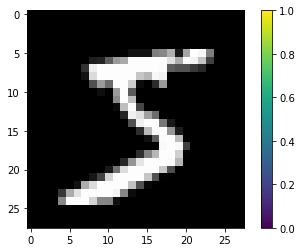

In [8]:
plt.figure()
plt.imshow(train[0])
plt.colorbar()

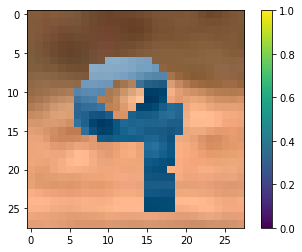

In [9]:
plt.imshow(train[60001])
plt.colorbar()

In [10]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

In [63]:
class MNISTModel(object):
    """Simple MNIST domain adaptation model."""
    def __init__(self):
        # models
        self.feature_model = self._feature_model()
        self.class_model = self._class_model()
        self.domain_model = self._domain_model()
        # losses & optimizer
        self.class_loss = losses.SparseCategoricalCrossentropy()
        self.domain_loss = losses.BinaryCrossentropy()
        self.optimizer = tf.keras.optimizers.Adam()
    
    def _feature_model(self):
        model = tf.keras.models.Sequential()
        model.add(layers.Conv2D(32, (5, 5),
                                activation='relu',
                                input_shape=(28, 28, 3),
                                padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Conv2D(64, (5, 5),
                                activation='relu',
                                padding='same'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
#         model.add(layers.Dense(100,
#                                activation='relu'))
        model.add(layers.Dense(10,
                               activation='relu'))
        return model
    
    def _class_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.feature_model)
        model.add(layers.Dense(10))
        model.add(layers.Softmax())
        return model
    
    def _domain_model(self):
        model = tf.keras.models.Sequential()
        model.add(self.feature_model)
        model.add(GradReverse()) # reverse the gradient
        model.add(layers.Dense(10,
                               activation='relu'))
        model.add(layers.Dense(1))
        model.add(layers.Softmax())
        return model
    
    @tf.function
    def train_dann(self, images, labels, origins):
        # classification
        mask = tf.dtypes.cast(origins, tf.bool)
        x_able = tf.boolean_mask(images, mask)
        y_able = tf.boolean_mask(labels, mask)
        
        with tf.GradientTape() as tape:
            pred_class = self.class_model(x_able)
            loss_class = self.class_loss(y_able, pred_class)
            
            pred_domain = self.domain_model(images)
            loss_domain = self.domain_loss(tf.reshape(origins, (-1, 1)), pred_domain)
            
            total_loss = loss_class + loss_domain
            
        tvars = self.class_model.trainable_variables + self.domain_model.trainable_variables
#         grads = tape.gradient(total_loss, tvars)
#         self.optimizer.apply_gradients(zip(grads, tvars))
        
        self.class_model.compile(self.optimizer, total_loss, metrics=['accuracy'])
        self.class_model.fit(images, labels, epochs=1, batch_size=64)
        
        return loss_class, loss_domain

    def train_asis(self, images, labels):
        self.class_model.compile(self.optimizer, self.class_loss, metrics=['accuracy'])
        self.class_model.fit(images, labels, epochs=1, batch_size=64)

In [64]:
dann = MNISTModel()
dann.class_model.compile(dann.optimizer, dann.class_loss, metrics=['accuracy'])
nn = MNISTModel()

In [67]:
type(dann.class_model)

tensorflow.python.keras.engine.sequential.Sequential

In [52]:
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices(
    (train.astype('float32'), labels, origins)).shuffle(102000).batch(batch_size)

In [65]:
train_loss_domain = []
train_loss_class = []
    
for _ in range(2):
    predc, predd, target = [], [], []
    epoch_loss_domain = metrics.Mean()
    epoch_loss_class = metrics.Mean()

    for train_b, label_b, origin_b in train_ds:
        lc, ld = dann.train_dann(train_b, label_b, origin_b)
        
        mask = tf.dtypes.cast(tf.reshape(origin_b, shape=[-1]), tf.bool)
        x_able = tf.boolean_mask(train_b, mask)
        y_able = tf.boolean_mask(label_b, mask)
        
        predc = np.append(predc, np.argmax(dann.class_model.predict(x_able), axis=1))
        predd = np.append(predd, np.argmax(dann.domain_model.predict(x_able), axis=1))
        target = np.append(target, y_able)
        
        epoch_loss_domain(ld)
        epoch_loss_class(lc)
        
    train_loss_domain.append(epoch_loss_domain.result())
    train_loss_class.append(epoch_loss_class.result())
    
    print("<Train>", end=' ')
    print("Domain Loss: {:.4}".format(epoch_loss_domain.result()), end=' || ')
    print("Class Loss: {:.4}".format(epoch_loss_class.result()), end=' || ')
    print("Class Accuracy: {:.2%}".format(np.sum(predc == np.reshape(target, (-1))) / len(predc)))
    dann.class_model.evaluate(mnist_test, y_test)

<Train> Domain Loss: 6.314 || Class Loss: 0.2012 || Class Accuracy: 94.91%
10000/10000 [==============================] - 4s 354us/sample - loss: 0.0537 - accuracy: 0.9841
<Train> Domain Loss: 6.314 || Class Loss: 0.05972 || Class Accuracy: 99.19%
10000/10000 [==============================] - 3s 329us/sample - loss: 0.0495 - accuracy: 0.9857


In [66]:
a, b, c = next(iter(train_ds))
print(c)
# dann.domain_model.predict()

tf.Tensor(
[0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0.], shape=(64,), dtype=float64)


In [29]:
np.argmax(dann.class_model(mnistm_test[:1].astype(np.float32)).numpy())

3

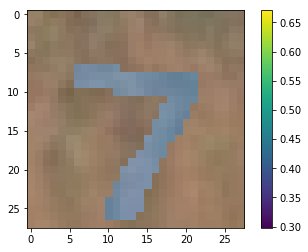

In [30]:
plt.figure()
plt.imshow(mnistm_test[0])
plt.colorbar()

In [118]:
mask = tf.dtypes.cast(backend.reshape(origins, shape=[-1]), tf.bool)
x_able = tf.boolean_mask(train, mask)
y_able = tf.boolean_mask(labels, mask)

# train nn
for _ in range(5):
    history = nn.train_asis(x_able, y_able)
    nn.class_model.evaluate(test, y_test)

10000/10000 [==============================] - 4s 362us/sample - loss: 0.0282 - accuracy: 0.9918


In [120]:
# Create a mixed dataset for TSNE visualization
num_test = 500
combined_test_imgs = np.vstack([mnist_test[:num_test], mnistm_test[:num_test]])

y_test2 = y_test.reshape(-1,1)
combined_test_labels = np.vstack([y_test2[:num_test], y_test2[:num_test]])
combined_test_domain = np.vstack([np.tile([1., 0.], [num_test, 1]),
                                  np.tile([0., 1.], [num_test, 1])])

In [121]:
dann_emb = dann.feature_model(combined_test_imgs.astype('float32'))
tsne_d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne_d.fit_transform(dann_emb)

In [122]:
nn_emb = nn.feature_model(combined_test_imgs.astype('float32'))
tsne_n = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
nn_tsne = tsne_n.fit_transform(nn_emb)

In [123]:
n = combined_test_labels.reshape(-1).astype('str')
z = dann_tsne[:,0]
y = dann_tsne[:,1]
z2 = nn_tsne[:,0]
y2 = nn_tsne[:,1]

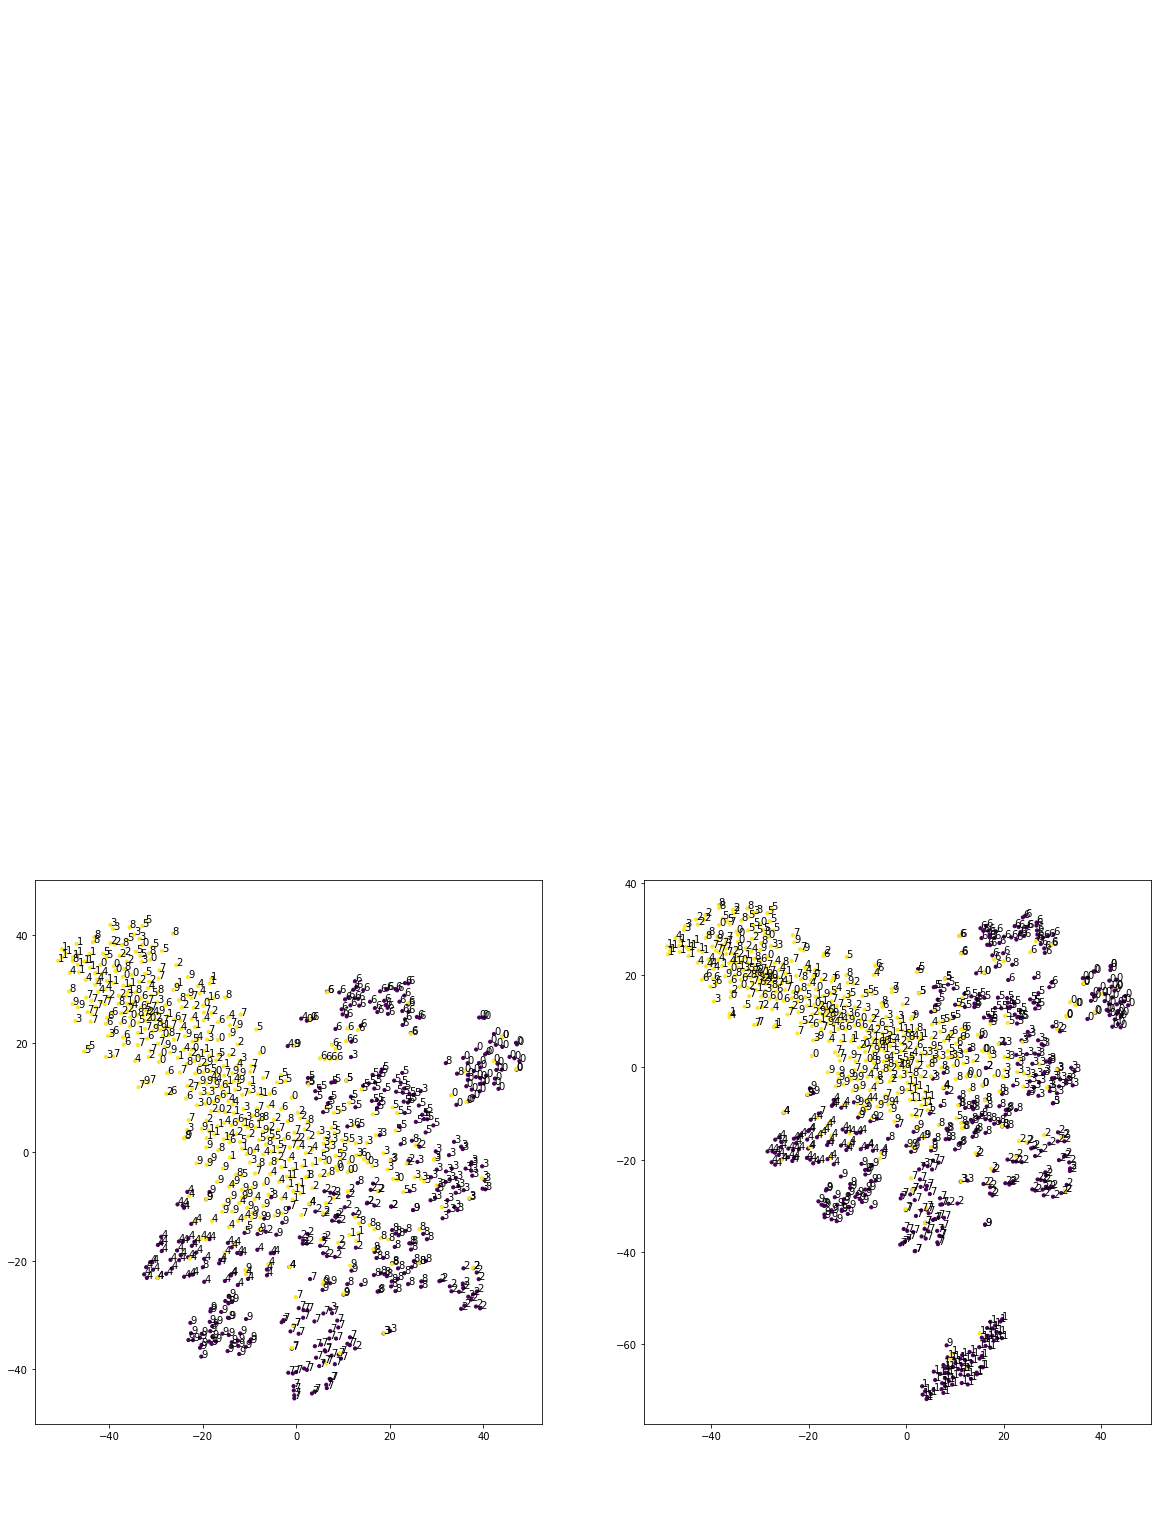

In [126]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(z, y, c=combined_test_domain.argmax(1), s=10)
for i, txt in enumerate(n):
    ax1.annotate(txt, (z[i], y[i]))
# ax1.set_xlim(-50,50)
ax1.set_ylim(-50,50)

ax2 = fig.add_subplot(1,2,2)
# ax2.set_xlim(-50,50)
# ax2.set_ylim(-50,50)
ax2.scatter(z2, y2, c=combined_test_domain.argmax(1), s=10)
for i, txt in enumerate(n):
    ax2.annotate(txt, (z2[i], y2[i]))